# **AI TECH INSTITUTE** · *Intermediate AI & Data Science*
### Week 03 · Notebook 03 — Data Warehouse Design
**Instructor:** Amir Charkhi  |  **Goal:** Building Analytical Foundations

> Format: theory → implementation → best practices → real-world application.
>
**Learning Objectives:**
- Understand OLTP vs OLAP systems and when to use each
- Master dimensional modeling (star and snowflake schemas)
- Design and implement fact and dimension tables
- Handle slowly changing dimensions (SCD Types 1, 2, 3)
- Build a production-ready data mart from scratch


## 🎯 The Big Picture: Why Data Warehouses?

Imagine you're Netflix:
- **Operational System (OLTP)**: Records every play, pause, skip - millions per second
- **Analytical System (OLAP)**: Answers "What shows do people binge on weekends?"

You can't run heavy analytics on your operational system - it would crash! Enter the data warehouse.

**Data Warehouse Benefits:**
- 🚀 Optimized for reading and aggregation
- 📊 Historical data preservation
- 🔄 Consistent business definitions
- 🎯 Single source of truth
- ⚡ Query performance at scale

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta
import json
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')

# Visualization for schema diagrams
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import seaborn as sns
sns.set_style('whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

def show_sql(query):
    """Pretty print SQL queries"""
    display(Markdown(f"```sql\n{query}\n```"))

print("✅ Environment ready for warehouse design!")

✅ Environment ready for warehouse design!


## 📊 Part 1: OLTP vs OLAP - The Fundamental Difference

Let's build the same business scenario in both paradigms to see the difference!

### 1.1 Creating an OLTP Database (Normalized)

OLTP follows normalization rules - no redundancy, referential integrity, optimized for transactions.

In [2]:
# Create OLTP database - highly normalized
oltp_conn = sqlite3.connect('oltp_retail.db')
oltp_cursor = oltp_conn.cursor()

# Drop existing tables
tables_to_drop = ['order_items', 'orders', 'products', 'categories', 'customers', 'addresses', 'stores']
for table in tables_to_drop:
    oltp_cursor.execute(f"DROP TABLE IF EXISTS {table}")

# Create normalized tables
# Categories table
oltp_cursor.execute("""
CREATE TABLE categories (
    category_id INTEGER PRIMARY KEY,
    category_name TEXT NOT NULL,
    parent_category_id INTEGER,
    FOREIGN KEY (parent_category_id) REFERENCES categories(category_id)
)
""")

# Products table
oltp_cursor.execute("""
CREATE TABLE products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT NOT NULL,
    category_id INTEGER,
    unit_price DECIMAL(10,2),
    unit_cost DECIMAL(10,2),
    FOREIGN KEY (category_id) REFERENCES categories(category_id)
)
""")

# Addresses table
oltp_cursor.execute("""
CREATE TABLE addresses (
    address_id INTEGER PRIMARY KEY,
    street TEXT,
    city TEXT,
    state TEXT,
    zip_code TEXT,
    country TEXT
)
""")

# Customers table
oltp_cursor.execute("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    email TEXT UNIQUE,
    phone TEXT,
    address_id INTEGER,
    created_date DATE,
    FOREIGN KEY (address_id) REFERENCES addresses(address_id)
)
""")

# Stores table
oltp_cursor.execute("""
CREATE TABLE stores (
    store_id INTEGER PRIMARY KEY,
    store_name TEXT,
    address_id INTEGER,
    manager_name TEXT,
    FOREIGN KEY (address_id) REFERENCES addresses(address_id)
)
""")

# Orders table
oltp_cursor.execute("""
CREATE TABLE orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    store_id INTEGER,
    order_date DATETIME,
    ship_date DATETIME,
    status TEXT,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
    FOREIGN KEY (store_id) REFERENCES stores(store_id)
)
""")

# Order items table
oltp_cursor.execute("""
CREATE TABLE order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    unit_price DECIMAL(10,2),
    discount DECIMAL(5,2),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
)
""")

oltp_conn.commit()
print("✅ OLTP schema created with 7 normalized tables")
print("\n📊 OLTP Characteristics:")
print("  - No data redundancy")
print("  - Strong referential integrity")
print("  - Optimized for INSERT/UPDATE/DELETE")
print("  - Requires multiple JOINs for analytics")

✅ OLTP schema created with 7 normalized tables

📊 OLTP Characteristics:
  - No data redundancy
  - Strong referential integrity
  - Optimized for INSERT/UPDATE/DELETE
  - Requires multiple JOINs for analytics


In [3]:
# Populate OLTP database with sample data
np.random.seed(42)

# Generate sample data
n_customers = 1000
n_products = 200
n_orders = 5000
n_stores = 10

# Categories
categories = pd.DataFrame({
    'category_id': range(1, 6),
    'category_name': ['Electronics', 'Clothing', 'Food', 'Books', 'Sports'],
    'parent_category_id': [None, None, None, None, None]
})

# Products
products = pd.DataFrame({
    'product_id': range(1, n_products + 1),
    'product_name': [f'Product_{i}' for i in range(1, n_products + 1)],
    'category_id': np.random.randint(1, 6, n_products),
    'unit_price': np.round(np.random.uniform(10, 500, n_products), 2),
    'unit_cost': np.round(np.random.uniform(5, 250, n_products), 2)
})

# Addresses
n_addresses = n_customers + n_stores
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix']
states = ['NY', 'CA', 'IL', 'TX', 'AZ']

addresses = pd.DataFrame({
    'address_id': range(1, n_addresses + 1),
    'street': [f'{np.random.randint(1, 9999)} Main St' for _ in range(n_addresses)],
    'city': np.random.choice(cities, n_addresses),
    'state': np.random.choice(states, n_addresses),
    'zip_code': [f'{np.random.randint(10000, 99999)}' for _ in range(n_addresses)],
    'country': 'USA'
})

# Customers
customers = pd.DataFrame({
    'customer_id': range(1, n_customers + 1),
    'first_name': [f'First_{i}' for i in range(1, n_customers + 1)],
    'last_name': [f'Last_{i}' for i in range(1, n_customers + 1)],
    'email': [f'customer_{i}@email.com' for i in range(1, n_customers + 1)],
    'phone': [f'555-{np.random.randint(1000, 9999)}' for _ in range(n_customers)],
    'address_id': range(1, n_customers + 1),
    'created_date': pd.date_range('2023-01-01', periods=n_customers, freq='6H').date
})

# Stores
stores = pd.DataFrame({
    'store_id': range(1, n_stores + 1),
    'store_name': [f'Store_{city}_{i}' for i, city in enumerate(np.random.choice(cities, n_stores), 1)],
    'address_id': range(n_customers + 1, n_customers + n_stores + 1),
    'manager_name': [f'Manager_{i}' for i in range(1, n_stores + 1)]
})

# Orders
orders = pd.DataFrame({
    'order_id': range(1, n_orders + 1),
    'customer_id': np.random.randint(1, n_customers + 1, n_orders),
    'store_id': np.random.randint(1, n_stores + 1, n_orders),
    'order_date': pd.date_range('2024-01-01', periods=n_orders, freq='2H'),
    'ship_date': pd.date_range('2024-01-02', periods=n_orders, freq='2H'),
    'status': np.random.choice(['Completed', 'Pending', 'Cancelled'], n_orders, p=[0.8, 0.15, 0.05])
})

# Order items (multiple items per order)
order_items = []
order_item_id = 1
for order_id in range(1, n_orders + 1):
    n_items = np.random.randint(1, 6)  # 1-5 items per order
    for _ in range(n_items):
        product = products.sample(1).iloc[0]
        order_items.append({
            'order_item_id': order_item_id,
            'order_id': order_id,
            'product_id': int(product['product_id']),
            'quantity': np.random.randint(1, 5),
            'unit_price': float(product['unit_price']),
            'discount': np.random.choice([0, 0.05, 0.10, 0.15], p=[0.6, 0.2, 0.15, 0.05])
        })
        order_item_id += 1

order_items_df = pd.DataFrame(order_items)

# Load data into OLTP database
categories.to_sql('categories', oltp_conn, if_exists='append', index=False)
products.to_sql('products', oltp_conn, if_exists='append', index=False)
addresses.to_sql('addresses', oltp_conn, if_exists='append', index=False)
customers.to_sql('customers', oltp_conn, if_exists='append', index=False)
stores.to_sql('stores', oltp_conn, if_exists='append', index=False)
orders.to_sql('orders', oltp_conn, if_exists='append', index=False)
order_items_df.to_sql('order_items', oltp_conn, if_exists='append', index=False)

print(f"✅ OLTP database populated:")
print(f"  - {len(categories)} categories")
print(f"  - {len(products)} products")
print(f"  - {len(customers)} customers")
print(f"  - {len(stores)} stores")
print(f"  - {len(orders)} orders")
print(f"  - {len(order_items_df)} order items")

✅ OLTP database populated:
  - 5 categories
  - 200 products
  - 1000 customers
  - 10 stores
  - 5000 orders
  - 15107 order items


### 1.2 The Pain of OLTP Analytics

Let's try a simple business question: "What's the total revenue by category last month?"

In [4]:
# Complex query needed for simple analytics in OLTP
oltp_analytics_query = """
SELECT 
    c.category_name,
    COUNT(DISTINCT o.order_id) as num_orders,
    SUM(oi.quantity) as total_quantity,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount)) as total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN categories c ON p.category_id = c.category_id
WHERE o.status = 'Completed'
  AND o.order_date >= '2024-01-01'
  AND o.order_date < '2024-02-01'
GROUP BY c.category_name
ORDER BY total_revenue DESC
"""

print("🔍 OLTP Query Complexity:")
show_sql(oltp_analytics_query)

# Execute and time it
import time
start = time.time()
oltp_result = pd.read_sql(oltp_analytics_query, oltp_conn)
oltp_time = time.time() - start

print(f"\n⏱️ Query execution time: {oltp_time:.3f} seconds")
print(f"📊 Joins required: 4")
print(f"\nResults:")
print(oltp_result)

🔍 OLTP Query Complexity:


```sql

SELECT 
    c.category_name,
    COUNT(DISTINCT o.order_id) as num_orders,
    SUM(oi.quantity) as total_quantity,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount)) as total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN categories c ON p.category_id = c.category_id
WHERE o.status = 'Completed'
  AND o.order_date >= '2024-01-01'
  AND o.order_date < '2024-02-01'
GROUP BY c.category_name
ORDER BY total_revenue DESC

```


⏱️ Query execution time: 0.013 seconds
📊 Joins required: 4

Results:
  category_name  num_orders  total_quantity  total_revenue
0         Books         153             534      156451.07
1   Electronics         137             427       99746.41
2        Sports         119             390       92370.72
3          Food         113             340       80902.01
4      Clothing         113             334       67044.38


---

## ⭐ Part 2: Star Schema - The Analytics Powerhouse

Now let's redesign this for analytics using a star schema!

### 2.1 Understanding Star Schema Components

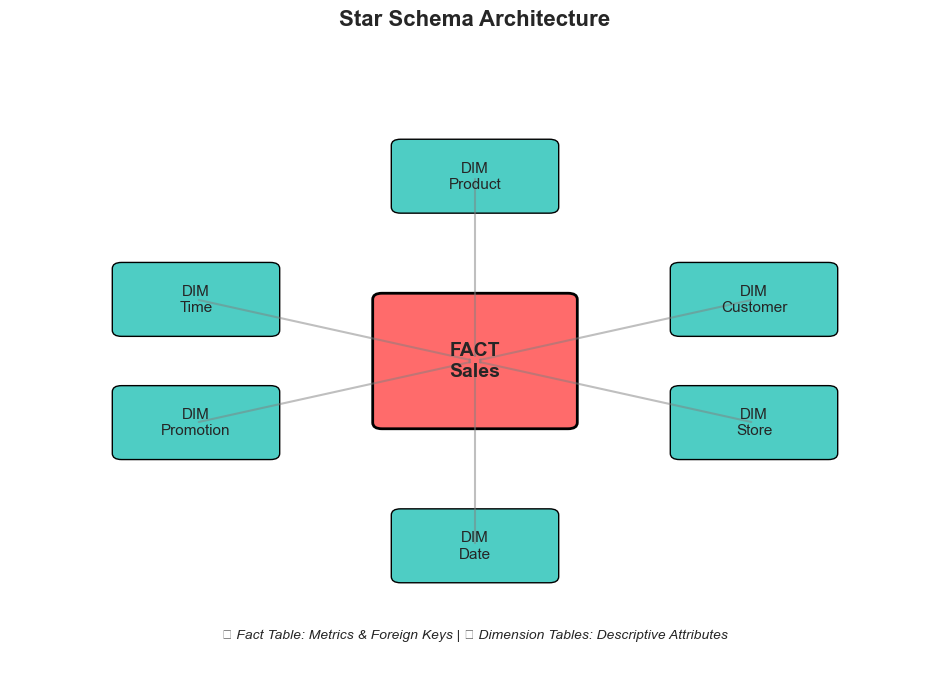


📝 Star Schema Principles:
1. **Fact Table**: Contains metrics (measures) and foreign keys to dimensions
2. **Dimension Tables**: Contains descriptive attributes for analysis
3. **Denormalized**: Trades storage for query performance
4. **Single Join**: Any analysis needs only one join per dimension


In [5]:
# Visualize star schema concept
fig, ax = plt.subplots(figsize=(12, 8))

# Central fact table
fact_box = FancyBboxPatch((0.4, 0.4), 0.2, 0.2, 
                          boxstyle="round,pad=0.01",
                          facecolor='#FF6B6B', edgecolor='black', linewidth=2)
ax.add_patch(fact_box)
ax.text(0.5, 0.5, 'FACT\nSales', ha='center', va='center', fontsize=14, fontweight='bold')

# Dimension tables
dimensions = [
    {'name': 'DIM\nProduct', 'pos': (0.5, 0.8), 'color': '#4ECDC4'},
    {'name': 'DIM\nCustomer', 'pos': (0.8, 0.6), 'color': '#4ECDC4'},
    {'name': 'DIM\nStore', 'pos': (0.8, 0.4), 'color': '#4ECDC4'},
    {'name': 'DIM\nDate', 'pos': (0.5, 0.2), 'color': '#4ECDC4'},
    {'name': 'DIM\nPromotion', 'pos': (0.2, 0.4), 'color': '#4ECDC4'},
    {'name': 'DIM\nTime', 'pos': (0.2, 0.6), 'color': '#4ECDC4'}
]

for dim in dimensions:
    dim_box = FancyBboxPatch((dim['pos'][0]-0.08, dim['pos'][1]-0.05), 0.16, 0.1,
                             boxstyle="round,pad=0.01",
                             facecolor=dim['color'], edgecolor='black', linewidth=1)
    ax.add_patch(dim_box)
    ax.text(dim['pos'][0], dim['pos'][1], dim['name'], ha='center', va='center', fontsize=11)
    
    # Draw connections
    arrow = FancyArrowPatch((dim['pos'][0], dim['pos'][1]), (0.5, 0.5),
                           connectionstyle="arc3,rad=0", 
                           arrowstyle='->', 
                           linewidth=1.5, color='gray', alpha=0.5)
    ax.add_patch(arrow)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Star Schema Architecture', fontsize=16, fontweight='bold', pad=20)

# Add legend
ax.text(0.5, 0.05, '🔴 Fact Table: Metrics & Foreign Keys | 🟢 Dimension Tables: Descriptive Attributes',
       ha='center', fontsize=10, style='italic')

plt.show()

print("\n📝 Star Schema Principles:")
print("1. **Fact Table**: Contains metrics (measures) and foreign keys to dimensions")
print("2. **Dimension Tables**: Contains descriptive attributes for analysis")
print("3. **Denormalized**: Trades storage for query performance")
print("4. **Single Join**: Any analysis needs only one join per dimension")

### 2.2 Building the Star Schema

In [6]:
# Create OLAP database with star schema
olap_conn = sqlite3.connect('olap_retail.db')
olap_cursor = olap_conn.cursor()

# Drop existing tables
tables_to_drop = ['fact_sales', 'dim_product', 'dim_customer', 'dim_store', 'dim_date']
for table in tables_to_drop:
    olap_cursor.execute(f"DROP TABLE IF EXISTS {table}")

# Create dimension tables
# Date dimension
olap_cursor.execute("""
CREATE TABLE dim_date (
    date_key INTEGER PRIMARY KEY,
    date DATE,
    year INTEGER,
    quarter INTEGER,
    month INTEGER,
    month_name TEXT,
    week INTEGER,
    day_of_month INTEGER,
    day_of_week INTEGER,
    day_name TEXT,
    is_weekend INTEGER,
    is_holiday INTEGER
)
""")

# Product dimension
olap_cursor.execute("""
CREATE TABLE dim_product (
    product_key INTEGER PRIMARY KEY,
    product_id INTEGER,
    product_name TEXT,
    category_name TEXT,
    brand TEXT,
    unit_price DECIMAL(10,2),
    unit_cost DECIMAL(10,2),
    margin_percent DECIMAL(5,2)
)
""")

# Customer dimension
olap_cursor.execute("""
CREATE TABLE dim_customer (
    customer_key INTEGER PRIMARY KEY,
    customer_id INTEGER,
    full_name TEXT,
    email TEXT,
    city TEXT,
    state TEXT,
    customer_segment TEXT
)
""")

# Store dimension
olap_cursor.execute("""
CREATE TABLE dim_store (
    store_key INTEGER PRIMARY KEY,
    store_id INTEGER,
    store_name TEXT,
    city TEXT,
    state TEXT,
    region TEXT,
    manager_name TEXT
)
""")

# Fact table
olap_cursor.execute("""
CREATE TABLE fact_sales (
    sale_key INTEGER PRIMARY KEY,
    date_key INTEGER,
    product_key INTEGER,
    customer_key INTEGER,
    store_key INTEGER,
    order_id INTEGER,
    quantity INTEGER,
    revenue DECIMAL(12,2),
    cost DECIMAL(12,2),
    profit DECIMAL(12,2),
    FOREIGN KEY (date_key) REFERENCES dim_date(date_key),
    FOREIGN KEY (product_key) REFERENCES dim_product(product_key),
    FOREIGN KEY (customer_key) REFERENCES dim_customer(customer_key),
    FOREIGN KEY (store_key) REFERENCES dim_store(store_key)
)
""")

# Create indexes
olap_cursor.execute("CREATE INDEX idx_fact_date ON fact_sales(date_key)")
olap_cursor.execute("CREATE INDEX idx_fact_product ON fact_sales(product_key)")
olap_cursor.execute("CREATE INDEX idx_fact_customer ON fact_sales(customer_key)")
olap_cursor.execute("CREATE INDEX idx_fact_store ON fact_sales(store_key)")

olap_conn.commit()
print("✅ Star schema created successfully!")

✅ Star schema created successfully!


### 2.3 ETL: Populating the Star Schema

In [7]:
# ETL Process - Transform OLTP data to OLAP star schema
print("🔄 Starting ETL Process...\n")

# 1. Build Date Dimension
print("1️⃣ Building Date Dimension...")
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2025-12-31')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

dim_date = pd.DataFrame({
    'date_key': [int(d.strftime('%Y%m%d')) for d in date_range],
    'date': date_range.date,
    'year': date_range.year,
    'quarter': date_range.quarter,
    'month': date_range.month,
    'month_name': date_range.strftime('%B'),
    'week': date_range.isocalendar().week,
    'day_of_month': date_range.day,
    'day_of_week': date_range.dayofweek,
    'day_name': date_range.strftime('%A'),
    'is_weekend': (date_range.dayofweek >= 5).astype(int),
    'is_holiday': 0
})

dim_date.to_sql('dim_date', olap_conn, if_exists='append', index=False)
print(f"   ✓ Loaded {len(dim_date)} dates")

# 2. Build Product Dimension
print("\n2️⃣ Building Product Dimension...")
products_query = """
SELECT 
    p.product_id,
    p.product_name,
    c.category_name,
    p.unit_price,
    p.unit_cost
FROM products p
JOIN categories c ON p.category_id = c.category_id
"""

dim_product = pd.read_sql(products_query, oltp_conn)
dim_product['product_key'] = range(1, len(dim_product) + 1)
dim_product['brand'] = 'Brand_' + (dim_product['product_id'] % 5).astype(str)
dim_product['margin_percent'] = ((dim_product['unit_price'] - dim_product['unit_cost']) / dim_product['unit_price'] * 100).round(2)

dim_product.to_sql('dim_product', olap_conn, if_exists='append', index=False)
print(f"   ✓ Loaded {len(dim_product)} products")

# 3. Build Customer Dimension
print("\n3️⃣ Building Customer Dimension...")
customers_query = """
SELECT 
    c.customer_id,
    c.first_name || ' ' || c.last_name as full_name,
    c.email,
    a.city,
    a.state
FROM customers c
JOIN addresses a ON c.address_id = a.address_id
"""

dim_customer = pd.read_sql(customers_query, oltp_conn)
dim_customer['customer_key'] = range(1, len(dim_customer) + 1)

# Assign customer segments randomly
dim_customer['customer_segment'] = np.random.choice(['Bronze', 'Silver', 'Gold'], len(dim_customer), p=[0.6, 0.3, 0.1])

dim_customer.to_sql('dim_customer', olap_conn, if_exists='append', index=False)
print(f"   ✓ Loaded {len(dim_customer)} customers")

# 4. Build Store Dimension
print("\n4️⃣ Building Store Dimension...")
stores_query = """
SELECT 
    s.store_id,
    s.store_name,
    a.city,
    a.state,
    s.manager_name
FROM stores s
JOIN addresses a ON s.address_id = a.address_id
"""

dim_store = pd.read_sql(stores_query, oltp_conn)
dim_store['store_key'] = range(1, len(dim_store) + 1)

# Map states to regions
region_map = {'NY': 'Northeast', 'CA': 'West', 'IL': 'Midwest', 'TX': 'South', 'AZ': 'West'}
dim_store['region'] = dim_store['state'].map(region_map)

dim_store.to_sql('dim_store', olap_conn, if_exists='append', index=False)
print(f"   ✓ Loaded {len(dim_store)} stores")

print("\n✅ Dimension tables loaded successfully!")

🔄 Starting ETL Process...

1️⃣ Building Date Dimension...
   ✓ Loaded 1096 dates

2️⃣ Building Product Dimension...
   ✓ Loaded 200 products

3️⃣ Building Customer Dimension...
   ✓ Loaded 1000 customers

4️⃣ Building Store Dimension...
   ✓ Loaded 10 stores

✅ Dimension tables loaded successfully!


In [8]:
# 5. Build Fact Table
print("5️⃣ Building Fact Table...\n")

# Extract order details from OLTP
fact_query = """
SELECT 
    oi.order_item_id,
    o.order_id,
    o.order_date,
    oi.product_id,
    o.customer_id,
    o.store_id,
    oi.quantity,
    oi.unit_price,
    oi.discount,
    p.unit_cost
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
WHERE o.status = 'Completed'
"""

fact_data = pd.read_sql(fact_query, oltp_conn)

# Create lookups for dimension keys
product_lookup = dim_product.set_index('product_id')['product_key'].to_dict()
customer_lookup = dim_customer.set_index('customer_id')['customer_key'].to_dict()
store_lookup = dim_store.set_index('store_id')['store_key'].to_dict()

# Transform to fact table structure
fact_sales = pd.DataFrame()
fact_sales['sale_key'] = range(1, len(fact_data) + 1)

# Date key transformation
fact_sales['date_key'] = pd.to_datetime(fact_data['order_date']).dt.strftime('%Y%m%d').astype(int)

# Dimension keys
fact_sales['product_key'] = fact_data['product_id'].map(product_lookup)
fact_sales['customer_key'] = fact_data['customer_id'].map(customer_lookup)
fact_sales['store_key'] = fact_data['store_id'].map(store_lookup)

# Measures
fact_sales['order_id'] = fact_data['order_id']
fact_sales['quantity'] = fact_data['quantity']
fact_sales['revenue'] = fact_data['quantity'] * fact_data['unit_price'] * (1 - fact_data['discount'])
fact_sales['cost'] = fact_data['quantity'] * fact_data['unit_cost']
fact_sales['profit'] = fact_sales['revenue'] - fact_sales['cost']

# Remove any rows with null keys
fact_sales = fact_sales.dropna()

# Load to OLAP database
fact_sales.to_sql('fact_sales', olap_conn, if_exists='append', index=False)

print(f"✓ Loaded {len(fact_sales):,} fact records")
print(f"✓ Total revenue: ${fact_sales['revenue'].sum():,.2f}")
print(f"✓ Total profit: ${fact_sales['profit'].sum():,.2f}")

print("\n✅ ETL Process Complete!")

5️⃣ Building Fact Table...

✓ Loaded 11,896 fact records
✓ Total revenue: $7,436,422.47
✓ Total profit: $3,655,116.14

✅ ETL Process Complete!


### 2.4 The Power of Star Schema Queries

In [9]:
# Same business question with star schema
star_analytics_query = """
SELECT 
    p.category_name,
    COUNT(DISTINCT f.order_id) as num_orders,
    SUM(f.quantity) as total_quantity,
    SUM(f.revenue) as total_revenue,
    SUM(f.profit) as total_profit
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
JOIN dim_date d ON f.date_key = d.date_key
WHERE d.year = 2024 
  AND d.month = 1
GROUP BY p.category_name
ORDER BY total_revenue DESC
"""

print("⭐ Star Schema Query Simplicity:")
show_sql(star_analytics_query)

# Execute and time it
start = time.time()
star_result = pd.read_sql(star_analytics_query, olap_conn)
star_time = time.time() - start

print(f"\n⏱️ Query execution time: {star_time:.3f} seconds")
print(f"📊 Joins required: 2 (only what we need!)")
print(f"\nResults:")
print(star_result)

# Compare performance
if oltp_time > 0:
    print(f"\n🚀 Performance Improvement: {(oltp_time/star_time):.1f}x faster!")

⭐ Star Schema Query Simplicity:


```sql

SELECT 
    p.category_name,
    COUNT(DISTINCT f.order_id) as num_orders,
    SUM(f.quantity) as total_quantity,
    SUM(f.revenue) as total_revenue,
    SUM(f.profit) as total_profit
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
JOIN dim_date d ON f.date_key = d.date_key
WHERE d.year = 2024 
  AND d.month = 1
GROUP BY p.category_name
ORDER BY total_revenue DESC

```


⏱️ Query execution time: 0.008 seconds
📊 Joins required: 2 (only what we need!)

Results:
  category_name  num_orders  total_quantity  total_revenue  total_profit
0         Books         153             534      156451.07      88606.40
1   Electronics         137             427       99746.41      35772.72
2        Sports         119             390       92370.72      42752.73
3          Food         113             340       80902.01      44464.02
4      Clothing         113             334       67044.38      21477.94

🚀 Performance Improvement: 1.5x faster!


---

## 🔄 Part 3: Slowly Changing Dimensions (SCD)

Real world data changes! How do we handle this in our warehouse?

In [10]:
# Demonstrate SCD Types
print("🔄 Slowly Changing Dimensions (SCD) Types\n")
print("Scenario: Customer 'John Doe' moves from New York to California\n")

# Original customer record
original = pd.DataFrame({
    'customer_key': [1],
    'customer_id': [1001],
    'name': ['John Doe'],
    'city': ['New York'],
    'state': ['NY']
})

print("Original Record:")
print(original)
print("\n" + "="*60 + "\n")

# Type 1: Overwrite
print("📝 SCD Type 1: Overwrite")
scd1 = original.copy()
scd1['city'] = 'Los Angeles'
scd1['state'] = 'CA'
print(scd1)
print("✅ Simple | ❌ Lost history\n")

# Type 2: Add new row
print("📝 SCD Type 2: Add New Row")
scd2 = pd.DataFrame({
    'customer_key': [1, 2],
    'customer_id': [1001, 1001],
    'name': ['John Doe', 'John Doe'],
    'city': ['New York', 'Los Angeles'],
    'state': ['NY', 'CA'],
    'effective_date': ['2023-01-01', '2024-06-01'],
    'is_current': [0, 1]
})
print(scd2)
print("✅ Full history | ❌ Complex queries\n")

# Type 3: Add column
print("📝 SCD Type 3: Add Column")
scd3 = original.copy()
scd3['current_city'] = 'Los Angeles'
scd3['previous_city'] = 'New York'
print(scd3[['customer_key', 'name', 'current_city', 'previous_city']])
print("✅ Track current & previous | ❌ Only one change")

🔄 Slowly Changing Dimensions (SCD) Types

Scenario: Customer 'John Doe' moves from New York to California

Original Record:
   customer_key  customer_id      name      city state
0             1         1001  John Doe  New York    NY


📝 SCD Type 1: Overwrite
   customer_key  customer_id      name         city state
0             1         1001  John Doe  Los Angeles    CA
✅ Simple | ❌ Lost history

📝 SCD Type 2: Add New Row
   customer_key  customer_id      name         city state effective_date  \
0             1         1001  John Doe     New York    NY     2023-01-01   
1             2         1001  John Doe  Los Angeles    CA     2024-06-01   

   is_current  
0           0  
1           1  
✅ Full history | ❌ Complex queries

📝 SCD Type 3: Add Column
   customer_key      name current_city previous_city
0             1  John Doe  Los Angeles      New York
✅ Track current & previous | ❌ Only one change


---

## 🎯 Practice Exercise

Design your own star schema for a streaming service!

In [11]:
# TODO: Design a star schema for Netflix-like service
# Think about:
# - Fact grain: viewing sessions
# - Dimensions: user, content, device, time
# - Measures: watch_time, completion_rate

print("Your turn! Design a streaming service star schema")
print("\nHint: Consider these dimensions:")
print("- dim_user (user_id, age_group, subscription_type)")
print("- dim_content (movie_id, title, genre, rating)")
print("- dim_device (device_type, platform)")
print("- dim_date (standard date dimension)")
print("\nAnd fact table:")
print("- fact_views (watch_duration, completion_pct, quality)")

Your turn! Design a streaming service star schema

Hint: Consider these dimensions:
- dim_user (user_id, age_group, subscription_type)
- dim_content (movie_id, title, genre, rating)
- dim_device (device_type, platform)
- dim_date (standard date dimension)

And fact table:
- fact_views (watch_duration, completion_pct, quality)


---

## 🎓 Key Takeaways

1. **OLTP vs OLAP**: Different designs for different purposes
2. **Star Schema**: Simple, fast, business-friendly
3. **ETL Process**: Transform normalized to dimensional
4. **SCD Types**: Handle changing data appropriately
5. **Performance**: Proper design = faster queries

## 🚀 Next Steps

Next notebook: Advanced SQL Analytics with window functions!

Remember: **Good warehouse design is the foundation of analytics!** 🏗️

In [12]:
# Cleanup
oltp_conn.close()
olap_conn.close()
print("✅ Connections closed. Great work!")

✅ Connections closed. Great work!
